# Authors: Hugo Laurençon (hugo.laurencon@gmail.com) and Charbel-Raphaël Ségerie (charbel-raphael.segerie@hotmail.fr)


# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points):__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
N_train = 100
batch_size_small = 10
batch_size_big = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
Xtrain_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_small,
                                          shuffle=False, num_workers=2,
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train)]))
X_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_big,
                                       shuffle=False, num_workers=2,
                                       sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train, len(trainset))]))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
Xtest_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_big,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

number_labels_class = [0 for i in range(len(classes))] # Number of labels in each class in the training set
dataiter = iter(Xtrain_loader)
for i in range(len(dataiter)):
    _, labels = dataiter.next()
    for lab in labels:
        number_labels_class[lab] += 1
print("Number of labels in each class in the training set:")
print(number_labels_class)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of labels in each class in the training set:
[6, 16, 13, 13, 11, 7, 7, 11, 4, 12]


This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

<font color='red'>We only have $N_{train}=100$ labels for the training set. If all classes are equal in length in the training set, this would mean that we have only $10$ samples per class, which is very small. If, instead, a certain class is under-represented, this is even worse. This is the case here where we are forced to take the first $100$ samples of the training set, even if the 9th class contains only 4 samples.</font>

<font color='red'>The evaluation of the training might be difficult because if the network has too many parameters, we will typically directly overfit on these $100$ examples after few epochs, especially for the class with only 4 samples. Even if the network does not have too many parameters, we can have an high variance output depending on the chosen training set, because when we choose a very small dataset, we can indeed expect that some small datasets contain better examples to learn from than others. Therefore, we will have to give details on the training set while giving accuracies at the end of the training since they are likely to depend on that.</font>

<font color='red'>Some solutions for these problems are the following: reducing the generality of the model by reducing its number of learnable parameters or reducing the number of epochs it is trained on, implementing some kind of regularization in the network (for example with dropout), and choosing a not too large learning rate in order not to converge too fast.</font>

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points):__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [3]:
# Code mainly adapted from https://github.com/kuangliu/pytorch-cifar

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def training(net, trainloader, testloader, n_epoch, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    for epoch in range(n_epochs):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print('Batch: ' + str((batch_idx +  1)) + ' / ' + str(len(trainloader)),
            #      '| Train loss: %.3f | Train acc: %.2f%% (%d/%d)' 
            #      % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        print('Train loss: %.3f | Train acc: %.2f%% (%d/%d)'
              % (train_loss/len(trainloader), 100.*correct/total, correct, total))
        
        net.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += targets.size(0)
                correct_test += predicted.eq(targets).sum().item()

        print('Test loss: %.3f | Test acc: %.2f%% (%d/%d)'
              % (test_loss/len(testloader), 100.*correct_test/total_test, correct_test, total_test))
        
        scheduler.step()
        

In [ ]:
learning_rate = 0.01
n_epochs = 25

net_part = ResNet18() # Network that will be trained on partial training data
net_part = net_part.to(device)
if device == 'cuda':
    net_part = torch.nn.DataParallel(net_part)
    cudnn.benchmark = True

training(net_part, Xtrain_loader, Xtest_loader, n_epochs, learning_rate)



Epoch: 0
Train loss: 4.743 | Train acc: 11.00% (11/100)
Test loss: 2454.084 | Test acc: 9.01% (901/10000)

Epoch: 1
Train loss: 3.517 | Train acc: 15.00% (15/100)
Test loss: 81.806 | Test acc: 16.05% (1605/10000)

Epoch: 2
Train loss: 2.631 | Train acc: 11.00% (11/100)
Test loss: 31.238 | Test acc: 15.43% (1543/10000)

Epoch: 3
Train loss: 2.470 | Train acc: 20.00% (20/100)
Test loss: 6.690 | Test acc: 17.30% (1730/10000)

Epoch: 4
Train loss: 2.235 | Train acc: 20.00% (20/100)
Test loss: 2.910 | Test acc: 17.05% (1705/10000)

Epoch: 5
Train loss: 2.131 | Train acc: 31.00% (31/100)
Test loss: 2.679 | Test acc: 18.49% (1849/10000)

Epoch: 6
Train loss: 2.152 | Train acc: 17.00% (17/100)
Test loss: 3.160 | Test acc: 16.49% (1649/10000)

Epoch: 7
Train loss: 1.877 | Train acc: 35.00% (35/100)
Test loss: 3.461 | Test acc: 16.80% (1680/10000)

Epoch: 8
Train loss: 1.975 | Train acc: 24.00% (24/100)
Test loss: 2.788 | Test acc: 18.31% (1831/10000)

Epoch: 9
Train loss: 1.893 | Train acc: 31

<font color='red'> We obtained the following results after training a ResNet-18 architecture for $25$ epochs, with an Adam optimizer, a learning rate of $0.01$ and a batch size of $10$, on $X_{train}$ (which contains only 100 labeled data points):</font>

| Model |  Number of  epochs | Train accuracy | Test accuracy |
|-------|--------|-------------|--------------------------------------|
|ResNet-18 trained on $X_{train}$|$25$|$63\%$ $(63/100)$|$21.65\%$ $(2165/10000)$|

<font color='red'>The test accuracy obtained when the model is trained on the whole dataset is $93.02\%$ according to [this GitHub repo](https://github.com/kuangliu/pytorch-cifar). According to the [original paper](https://arxiv.org/pdf/1512.03385.pdf), results are a bit worse because a ResNet-20 architecture, which is a bit more expressive than a ResNet-18 architecture, achieved a test accuracy of $91.25\%$.</font>


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [4]:
# New transformation to rescale images
transform_resize = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

trainset_resize = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_resize)
Xtrain_loader_resize = torch.utils.data.DataLoader(trainset_resize, batch_size=batch_size_small,
                                                   shuffle=False, num_workers=2,
                                                   sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train)]))
X_loader_resize = torch.utils.data.DataLoader(trainset_resize, batch_size=batch_size_big,
                                              shuffle=False, num_workers=2,
                                              sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train, len(trainset))]))

testset_resize = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=transform_resize)
Xtest_loader_resize = torch.utils.data.DataLoader(testset_resize, batch_size=batch_size_big,
                                                  shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(512, len(classes))

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.nn.DataParallel(resnet18)
    cudnn.benchmark = True

learning_rate = 0.01
n_epochs = 15
training(resnet18, Xtrain_loader_resize, Xtest_loader_resize, n_epochs, learning_rate)


Epoch: 0
Train loss: 4.749 | Train acc: 14.00% (14/100)
Test loss: 3.344 | Test acc: 12.07% (1207/10000)

Epoch: 1
Train loss: 2.908 | Train acc: 38.00% (38/100)
Test loss: 2.916 | Test acc: 32.06% (3206/10000)

Epoch: 2
Train loss: 1.435 | Train acc: 59.00% (59/100)
Test loss: 1.950 | Test acc: 40.73% (4073/10000)

Epoch: 3
Train loss: 1.255 | Train acc: 67.00% (67/100)
Test loss: 2.084 | Test acc: 37.05% (3705/10000)

Epoch: 4
Train loss: 0.677 | Train acc: 78.00% (78/100)
Test loss: 1.787 | Test acc: 42.27% (4227/10000)

Epoch: 5
Train loss: 0.330 | Train acc: 93.00% (93/100)
Test loss: 1.650 | Test acc: 48.43% (4843/10000)

Epoch: 6
Train loss: 0.315 | Train acc: 91.00% (91/100)
Test loss: 1.739 | Test acc: 44.04% (4404/10000)

Epoch: 7
Train loss: 0.282 | Train acc: 92.00% (92/100)
Test loss: 1.495 | Test acc: 51.33% (5133/10000)

Epoch: 8
Train loss: 0.300 | Train acc: 92.00% (92/100)
Test loss: 2.097 | Test acc: 41.06% (4106/10000)

Epoch: 9
Train loss: 0.310 | Train acc: 89.00

<font color='red'> We obtained the following result after training a pretrained ResNet-18 architecture on ImageNet, and fine-tuning its last layer, for $15$ epochs, with an Adam optimizer, a learning rate of $0.01$ and a batch size of $10$, on $X_{train}$ (which contains only 100 labeled data points):</font>

| Model |  Number of  epochs | Train accuracy | Test accuracy |
|-------|--------|-------------|--------------------------------------|
|Pretrained ResNet-18 + fine-tuned last layer|$15$|$100\%$ $(100/100)$|$48.02\%$ $(4802/10000)$|

<font color='red'>We resized images of CIFAR to match the dimension of images of ImageNet (224x224).</font>

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points):__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

<font color='red'>When working with translations, because the image in question is contained on a finished support, we can end up with edge effects that need to be taken into account.</font>

- <font color='red'>For small transformations, edge effects mean that you have to manually add pixels on the side opposite the translation. For example, for a 32*32 image, if we translate to the right of 5 pixels, we need to fill the pixels on the left (padding). To do this, we can either use symmetry, uniform black or white padding or the average color of the image, random pixels, or an algorithm as a patch match, which fills the pixels by, looking for the closest patches in the image.You can then choose the padding algorithm according to the prior you have on the processed images.</font>


- <font color='red'>For medium transformations, in addition to padding problems, we can end up with semantic problems. Indeed, in a dog picture, the whole picture does not uniformly contain the information of the dog's presence because maybe the dog is only on the right side of the picture. If we translate the image to the right, we can lose the dog entirely from the image and end up with the cat that was located on the left of the image. To solve this problem, you can use gradCam to check after training which area contains the most important information for the algorithm.</font>

- <font color='red'>For large transformations, recognition becomes impossible: for example, for all right-side translations over 32 pixels for images with 32 pixels sides, the entire image is lost. This establishes an upper bound on the amount of data augmentation that can be added to the datasets for a given technique.</font>

<font color='red'>Here are other examples of considerations for other types of transformations: </font>

- <font color='red'>For example, for linear transformations: if we horizontally expand a car image, we must be careful that the label "limousine" is not in the labels considered.</font>
- <font color='red'>Similarly, colors sometimes carry semantic information: if we build an application to help people consume seasonal fruits, the color of the fruit is important.</font>
- <font color='red'>For rotations, for example in MNIST, one must be careful not to use 180 degrees rotations (and even 90 degrees! It is very deceitful) between 6 and 9.</font>

<font color='red'>In conclusion, in a general way, it is necessary to take care that the transformations used are independent of the semantics of the classes that are present.</font>

<font color='red'>However, if we are careful with these perturbations, and we add for example a gaussian noise to images, then it can improve the stability of the network, that will be less likely to directly overfit on the really small dataset that we had.</font>

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [5]:
class GaussianNoise(object):
    def __init__(self, std_max):
        self.mean = 0
        self.std = torch.rand(1) * std_max
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transform_augm = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomCrop(32, padding=4),
                                     transforms.RandomRotation(25),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     GaussianNoise(0.5)])

trainset_augm = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_augm)
Xtrain_loader_augm = torch.utils.data.DataLoader(trainset_augm, batch_size=batch_size_small,
                                                 shuffle=False, num_workers=2,
                                                 sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train)]))
X_loader_augm = torch.utils.data.DataLoader(trainset_augm, batch_size=batch_size_big,
                                            shuffle=False, num_workers=2,
                                            sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train, len(trainset))]))


Files already downloaded and verified


In [ ]:
learning_rate = 0.01
n_epochs = 40

net_part_augm = ResNet18() # Network that will be trained on partial training data with data augmentation
net_part_augm = net_part_augm.to(device)
if device == 'cuda':
    net_part_augm = torch.nn.DataParallel(net_part_augm)
    cudnn.benchmark = True

training(net_part_augm, Xtrain_loader_augm, Xtest_loader, n_epochs, learning_rate)


Epoch: 0
Train loss: 4.957 | Train acc: 8.00% (8/100)
Test loss: 18919.740 | Test acc: 10.00% (1000/10000)

Epoch: 1
Train loss: 3.774 | Train acc: 13.00% (13/100)
Test loss: 77.900 | Test acc: 15.10% (1510/10000)

Epoch: 2
Train loss: 3.094 | Train acc: 11.00% (11/100)
Test loss: 7.478 | Test acc: 10.12% (1012/10000)

Epoch: 3
Train loss: 2.531 | Train acc: 12.00% (12/100)
Test loss: 2.950 | Test acc: 14.53% (1453/10000)

Epoch: 4
Train loss: 2.307 | Train acc: 18.00% (18/100)
Test loss: 2.584 | Test acc: 14.97% (1497/10000)

Epoch: 5
Train loss: 2.327 | Train acc: 14.00% (14/100)
Test loss: 2.653 | Test acc: 16.42% (1642/10000)

Epoch: 6
Train loss: 2.108 | Train acc: 25.00% (25/100)
Test loss: 2.955 | Test acc: 18.01% (1801/10000)

Epoch: 7
Train loss: 2.156 | Train acc: 14.00% (14/100)
Test loss: 2.678 | Test acc: 18.19% (1819/10000)

Epoch: 8
Train loss: 2.086 | Train acc: 19.00% (19/100)
Test loss: 2.777 | Test acc: 18.15% (1815/10000)

Epoch: 9
Train loss: 2.094 | Train acc: 20

<font color='red'>The data augmentation techniques that we used are the following (they are done not directly on the training set, but after taking a batch during the training): a random horizontal flip with probability $0.5$, a random crop of the same size of the image that we augmented with a padding of $4$, a random rotation of between -25 and 25 degrees, a gaussian noise with mean 0 and with standard deviation a random number taken uniformly between $0$ and $0.5$.</font>

<font color='red'> After training the ResNet-18 architecture of the Question 3, we obtained the following result after $40$ epochs, with an Adam optimizer, a learning rate of $0.01$ and a batch size of $10$, on $X_{train}$ (which contains only 100 labeled data points):</font>

| Model |  Number of  epochs | Train accuracy | Test accuracy |
|-------|--------|-------------|--------------------------------------|
|ResNet-18 trained on $X_{train}$ + data augmentation|$40$|$44\%$ $(44/100)$|$23.37\%$ $(2337/10000)$|

<font color='red'>It is indeed a bit better than what we obtained without data augmentation.</font>

# Conclusions

__Question 7 (5 points):__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

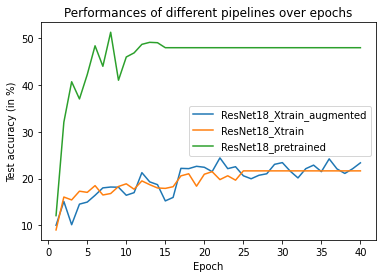

In [ ]:
ResNet18_Xtrain = [9.01, 16.05, 15.43, 17.30, 17.05, 18.49, 16.49, 16.80, 18.31, 18.88, 17.72, 19.50, 18.70, 17.99, 17.90, 18.26, 20.58, 21.03, 18.37, 20.93, 21.48, 19.78, 20.60, 19.66, 21.65] + [21.65 for i in range(15)]

ResNet18_pretrained = [12.07, 32.06, 40.73, 37.05, 42.27, 48.43, 44.04, 51.33, 41.06, 46.03, 46.91, 48.74, 49.17, 49.09, 48.02] + [48.02 for i in range(25)]

ResNet18_Xtrain_augmented = [10, 15.10, 10.12, 14.53, 14.97, 16.42, 18.01, 18.19, 18.15, 16.43, 16.99, 21.27, 19.30, 18.70, 15.22, 15.97, 22.19, 22.13, 22.63, 22.42, 21.49, 24.43, 22.13, 22.54, 20.60, 19.96, 20.71, 21.03, 23.05, 23.42, 21.60, 20.14, 22.12, 22.88, 21.48, 24.22, 22.07, 21.10, 22.10, 23.37]

plt.plot([i for i in range(1, 41)], ResNet18_Xtrain_augmented, label='ResNet18_Xtrain_augmented')
plt.plot([i for i in range(1, 41)], ResNet18_Xtrain, label='ResNet18_Xtrain')
plt.plot([i for i in range(1, 41)], ResNet18_pretrained, label='ResNet18_pretrained')
plt.title('Performances of different pipelines over epochs')
plt.ylabel('Test accuracy (in %)')
plt.xlabel('Epoch')
plt.legend()
plt.show()


<font color='red'>Here is a summary of what we obtained with the different pipelines:</font>

| Model |  Number of  epochs | Train accuracy | Test accuracy |
|-------|--------|-------------|--------------------------------------|
|ResNet-18 trained on $X_{train}$|$25$|$63\%$ $(63/100)$|$21.65\%$ $(2165/10000)$|
|ResNet-18 trained on $X_{train}$ + data augmentation|$40$|$44\%$ $(44/100)$|$23.37\%$ $(2337/10000)$|
|Pretrained ResNet-18 + fine-tuned last layer|$15$|$100\%$ $(100/100)$|$48.02\%$ $(4802/10000)$|

<font color='red'>**Regarding the first method, which is training a model from scratch with the small dataset available:**</font>

<font color='red'>The pros are that we do not have to have access to the weights of a pretrained model (some are publicly available, but some are not), and we don't have to design a data augmentation technique. This technique is the simplest to implement in practice.</font>

<font color='red'>However, there are cons. First, since the dataset is really small, the network will learn perfectly or almost perfectly to label the training data after few epochs, and hence the gradient becomes smaller and smaller and the network stops to learn. You are really dependent on the small training data you have, and it can be bad if you have in this dataset a sort of outlier for a certain class that is over-represented.</font>

<font color='red'>**Regarding the second method, which is training a model from scratch with the small dataset available and a data augmentation technique:**</font>

<font color='red'>One advantage is that the network will be more robust against small transformations in an image. Studies found that adding a very small noise to an image because feeding it to a network can lead to a completely different predicted label, while the transformation is imperceptible for a human. Therefore, we would like to be robust against this to be more performant on new data. The network will also not directly overfit on the training examples, because since transformations are random, we typically have different images all the time during the training. Data augmentation can also be used to remove a bias in a dataset. For example, there is a law in the US that states that soap dispenser should be as accurate as detecting white hands as for any other hand color. Data augmentation is a practical way to adjust the dataset for minorities.</font>

<font color='red'>A drawback is that you have to choose the right transformations for you dataset in your data augmentation techniques, or results can become worse. For example, if you rotate images randomly at 180 degrees, then the network will not be able to distinguish between a 6 and a 9. Another drawback is that the training will be typically longer because it will be harder for the network to overfit on the training data. The training is also likely to have more variance since a random transformation will be applied to each batch during the training, and the gradient computed at each step will of course depend on this random transformations.</font>

<font color='red'>**Regarding the third method, which is fine-tuning the last layer of a model pretrained on another task:**</font>

<font color='red'>One advantage is that the network has seen before (during the training of the original task) many more images than what we have in our dataset. Therefore, it is already able to detect features in an image like shapes, edges, colors, etc..., and all of this knowledge will be useful for our similar task. It is in practice really useful to use a pretrained model and performances are usually much higher. It is especially used either when we have a small training set, or when we don't have the computational power to train a full network.</font>

<font color='red'>A drawback is that the deeper we go in the network, the more specific to the original task the features will be. Therefore, it might capture features that are really useful for the previous task but not for ours, and fail to capture features important for our task if we re-train only the last layer. Moreover, if we had access to a huge number of data for our task, and an important computational power, and the previous task is not exactly the same as ours, it would be better to re-train the full model from scratch to our task, since the pre-trained model is likely to end up quickly in a local minimum, and in the end performs worse than the model trained from scratch.</font>

# Weak supervision

__Bonus \[open\] question (up to 3 points):__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In [38]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_weak_augm = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomCrop(32, padding=4),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_strong_augm = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomCrop(32, padding=4),
                                     transforms.RandomRotation(40),
                                     #transforms.ColorJitter(brightness=(0.2, 2), contrast=(0.2, 2), saturation=(0.2, 2), hue=(-0.3, 0.3)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                     GaussianNoise(2)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
Xtrain_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_small,
                                          shuffle=False, num_workers=2,
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler([i for i in range(N_train)]))

trainset_weak_augm = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True, transform=transform_weak_augm)
X_loader = torch.utils.data.DataLoader(trainset_weak_augm, batch_size=batch_size_big,
                                       shuffle=False, num_workers=2)


trainset_strong_augm = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                    download=True, transform=transform_strong_augm)
X_loader_augm = torch.utils.data.DataLoader(trainset_strong_augm, batch_size=batch_size_big,
                                            shuffle=False, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
Xtest_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_big,
                                           shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [28]:
from itertools import cycle
def training_SSL(net, trainloader_clean_labeled, trainloader_clean_unlabeled, trainloader_unclean_unlabeled, testloader, lambda_un, thr_select, n_epoch, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    for epoch in range(n_epochs):
        print('\nEpoch: %d' % epoch)
        net.train()
        supervised_train_loss = 0
        unsupervised_train_loss = 0
        correct = 0
        total = 0
        for batch_idx, ((inputs, targets_supervised), (inputs_clean, targets), (inputs_unclean, _)) in enumerate(zip(cycle(trainloader_clean_labeled),
                                                                                                                     trainloader_clean_unlabeled,
                                                                                                                     trainloader_unclean_unlabeled)):
            
            optimizer.zero_grad()

            inputs, targets_supervised = inputs.to(device), targets_supervised.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets_supervised)

            inputs_clean, inputs_unclean, targets = inputs_clean.to(device), inputs_unclean.to(device), targets.to(device)
            outputs_clean = net(inputs_clean)
            outputs_unclean = net(inputs_unclean)

            softmax = torch.softmax(outputs_clean, dim=1)
            max_elements, max_indices = torch.max(softmax, dim=1)
            indices = torch.squeeze((max_elements > thr_select).nonzero())
            outputs_unclean = outputs_unclean[indices]
            max_indices = max_indices[indices]

            if max_indices.dim() > 0:
                if not np.isnan((lambda_un * criterion(outputs_unclean, max_indices)).item()):
                    supervised_train_loss += loss.item()
                    unsupervised_train_loss += (lambda_un * criterion(outputs_unclean, max_indices)).item()
                    loss += lambda_un * criterion(outputs_unclean, max_indices)

            if not np.isnan(loss.item()):
                loss.backward()
                optimizer.step()

            _, predicted = outputs.max(1)
            total += targets_supervised.size(0)
            correct += predicted.eq(targets_supervised).sum().item()

        print('Supervised train loss: %.3f | Unsupervised train loss: %.3f | Train acc: %.2f%% (%d/%d)'
              % (supervised_train_loss, unsupervised_train_loss, 100.*correct/total, correct, total))
        
        net.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += targets.size(0)
                correct_test += predicted.eq(targets).sum().item()

        print('Test acc: %.2f%% (%d/%d)'
              % (100.*correct_test/total_test, correct_test, total_test))
        
        scheduler.step()

In [29]:
lambda_un = 1
thr_select = 0.95
learning_rate = 0.03
n_epochs = 20

resnet18 = ResNet18()
resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.nn.DataParallel(resnet18)
    cudnn.benchmark = True

training_SSL(resnet18, Xtrain_loader, X_loader, X_loader_augm, Xtest_loader, lambda_un, thr_select, n_epochs, learning_rate)


Epoch: 0
Supervised train loss: 457.100 | Unsupervised train loss: 142.338 | Train acc: 60.54% (2367/3910)
Test acc: 21.12% (2112/10000)

Epoch: 1
Supervised train loss: 80.418 | Unsupervised train loss: 209.022 | Train acc: 93.66% (3662/3910)
Test acc: 20.30% (2030/10000)

Epoch: 2
Supervised train loss: 47.937 | Unsupervised train loss: 184.787 | Train acc: 96.57% (3776/3910)
Test acc: 19.72% (1972/10000)

Epoch: 3
Supervised train loss: 26.556 | Unsupervised train loss: 181.076 | Train acc: 98.08% (3835/3910)
Test acc: 18.05% (1805/10000)

Epoch: 4
Supervised train loss: 18.602 | Unsupervised train loss: 173.867 | Train acc: 98.54% (3853/3910)
Test acc: 18.53% (1853/10000)

Epoch: 5
Supervised train loss: 9.835 | Unsupervised train loss: 181.862 | Train acc: 99.34% (3884/3910)
Test acc: 18.92% (1892/10000)

Epoch: 6
Supervised train loss: 7.805 | Unsupervised train loss: 177.228 | Train acc: 99.51% (3891/3910)
Test acc: 19.35% (1935/10000)

Epoch: 7
Supervised train loss: 11.157 | 

<font color='red'>In the previous cells, we tried to implement the [FixMatch](https://arxiv.org/pdf/2001.07685.pdf) algorithm, which is apparently the state of the art method for semi-supervised learning on CIFAR-10.</font>

<font color='red'>In this algorithm, we design two sets of transforms, ones that are weak, and the others that are strong. The network is trained such that it classifies well the labeled data (supervised loss), and such that the predictions on strong augmented data are similar to predictions on weak augmented data when the network is confident on the weak ones (unsupervised loss).</font>

<font color='red'>As stated in the paper, this heavily depends on the hyperparameters and the transformations we make. Here, we haven't put all the transformations used in the original paper (there are a lot) and we didn't have time to play a lot with the hyperparameters. We achieved a $24.43\%$ accuracy on the test set for $20$ epochs, and it might go higher for more epochs. This is much less than what they obtained in the original paper (we don't know for how many epochs they trained it), and we think this is  mostly because of the transformation choices (for example, adding one wrong transformation can ruin completely the results). However, we still achieved an increase in the accuracy of the test set of about $3\%$ compared to a fully supervised training.</font>